In [1]:
import os
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [2]:
import time
start = time.time()

In [3]:
data_dir = './datasets/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [4]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [6]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [8]:
model = Sequential()
model.add(layers.GRU(32,
                     #dropout=0.2,    # cuDNN을 사용할 수 없기 때문에 (???)
                     #recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

c:\Users\ADmin\anaconda3\envs\tf26\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
500/500 [==============================] - 51s 100ms/step - loss: 0.3010 - val_loss: 0.2748
Epoch 2/40
500/500 [==============================] - 50s 100ms/step - loss: 0.2845 - val_loss: 0.2654
Epoch 3/40
500/500 [==============================] - 49s 99ms/step - loss: 0.2780 - val_loss: 0.2688
Epoch 4/40
500/500 [==============================] - 50s 101ms/step - loss: 0.2732 - val_loss: 0.2644
Epoch 5/40
500/500 [==============================] - 49s 99ms/step - loss: 0.2684 - val_loss: 0.2659
Epoch 6/40
500/500 [==============================] - 49s 98ms/step - loss: 0.2624 - val_loss: 0.2617
Epoch 7/40
500/500 [==============================] - 49s 97ms/step - loss: 0.2584 - val_loss: 0.2678
Epoch 8/40
500/500 [==============================] - 49s 98ms/step - loss: 0.2539 - val_loss: 0.2701
Epoch 9/40
500/500 [==============================] - 48s 97ms/step - loss: 0.2507 - val_loss: 0.2753
Epoch 10/40
500/500 [==============================] - 50s 100ms/step - loss: 0

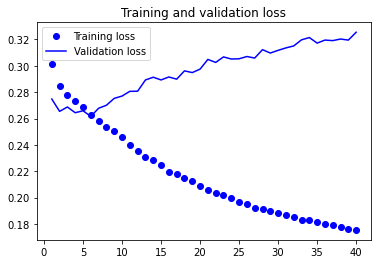

In [9]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
print(f"elapsed time: {time.time() - start}")

elapsed time: 1971.2558133602142
